In [1]:
using PyPlot, LinearAlgebra

# Circulant Matrices

In this lecture, I want to introduce you to a new type of matrix: **circulant** matrices.  Like Hermitian matrices, they have orthonormal eigenvectors, but unlike Hermitian matrices we know *exactly* what their eigenvectors are!  Moreover, their eigenvectors are closely related to the famous Fourier transform and Fourier series.  Even more importantly, it turns out that circulant matrices and the eigenvectors lend themselves to **incredibly efficient** algorithms called FFTs, that play a central role in much of computational science and engineering.

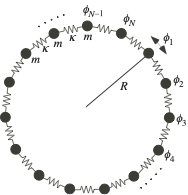

Consider a system of $n$ identical masses $m$ connected by springs $k$, sliding around a *circle* without friction.   Similar to our mass-and-spring lectur, the vector $\vec{s}$ of displacements satifies $m\frac{d^2\vec{s}}{dt^2} = -kA\vec{s}$, where $A$ is the $n \times n$ matrix:

$$
\begin{aligned}
A &= D^T \underbrace{\begin{pmatrix}
-1 & 1 & 0 & 0 & 0\\
0 & -1 & 1 & 0 & 0\\
0 & 0 & \ddots & \ddots & 0\\
0 & 0 & 0 & -1 & 1\\
1 & 0 & 0 & 0 & -1\\
\end{pmatrix}}_D \\
&= \begin{pmatrix} 2 & -1 & & & & & -1 \\
                   -1 & 2 &-1& & & & \\
                      &-1 &2&-1& & & \\
                      &   &\ddots&\ddots&\ddots& & \\ 
                   & & &-1 & 2  &-1 & \\
                   & & & & -1 &2 & -1 \\
                   -1 &   &  &  & &-1 &2
    \end{pmatrix}
\end{aligned}
$$

(This matrix is real-symmetric and, by the $D^T D$ construction, positive semidefinite.  So, it should have orthogonal eigenvectors and real eigenvalues $\lambda \ge 0$.)

For example, if $n = 7$:

In [2]:
A = [ 2 -1  0  0  0  0 -1
     -1  2 -1  0  0  0  0
      0 -1  2 -1  0  0  0
      0  0 -1  2 -1  0  0
      0  0  0 -1  2 -1  0
      0  0  0  0 -1  2 -1
     -1  0  0  0  0 -1  2]

7×7 Matrix{Int64}:
  2  -1   0   0   0   0  -1
 -1   2  -1   0   0   0   0
  0  -1   2  -1   0   0   0
  0   0  -1   2  -1   0   0
  0   0   0  -1   2  -1   0
  0   0   0   0  -1   2  -1
 -1   0   0   0   0  -1   2

This matrix has a very special pattern: *every row is the same as the previous row, just shifted to the right by 1* (wrapping around "cyclically" at the edges).  That is, each row is a [circular shift](https://en.wikipedia.org/wiki/Circular_shift) of the first row.

This is called a [circulant matrix](https://en.wikipedia.org/wiki/Circulant_matrix).  A $4\times 4$ circulant matrix looks like:

$$
C = \begin{pmatrix}
c_0 & c_1 & c_2 & c_3 \\
c_3 & c_0 & c_1 & c_2 \\
c_2 & c_3 & c_0 & c_1 \\
c_1 & c_2 & c_3 & c_0
\end{pmatrix}
$$

The general form of an $n \times n$ circulant matrix $C$ is:

$$
C = \begin{pmatrix}
c_0 & c_1 & c_2 & \cdots & c_{n-1} \\
c_{n-1} & c_0 & c_1 & c_2 & \cdots \\
c_{n-2} & c_{n-1} & c_0 & \cdots \\
\ddots & \ddots & \ddots & \ddots & \ddots \\
c_1 & c_2 & \cdots & c_{n-1} & c_0 
\end{pmatrix}
$$

When working with circulant matrix, it is convenient to number entries from $0$ to $n-1$ rather than from $1$ to $n$!

## Multiplying by circulant matrices: Convolutions

Suppose we have an $n \times n$ circulant matrix $C$ that we want to multiply by a vector $x = (x_0, x_1, \ldots, x_n)$.   It turns out that the result is a very special kind of operation:

$$
y = Cx = \begin{pmatrix}
c_0 & c_1 & c_2 & \cdots & c_{n-1} \\
c_{n-1} & c_0 & c_1 & c_2 & \cdots \\
c_{n-2} & c_{n-1} & c_0 & \cdots \\
\ddots & \ddots & \ddots & \ddots & \ddots \\
c_1 & c_2 & \cdots & c_{n-1} & c_0 
\end{pmatrix} \begin{pmatrix} x_0 \\ x_1 \\ \vdots \\ x_{n-1} \end{pmatrix}
$$

Let's write down a formula for the entries of $y$:

$$
y_0 = c_0 x_0 + c_1 x_1 + c_2 x_2 + \cdots \\
y_1 = c_{n-1} x_0 + c_0 x_1 + c_1 x_2 + \cdots \\
y_2 = c_{n-2} x_0 + c_{n-1} x_1 + c_0 x_2 + \cdots
$$

Can you see the pattern?  This is one of those cases that is actually clearer if we write out the summation:

$$
y_k = \sum_{j=0}^{n-1} c_{j-k} x_j
$$

There is a slight problem with this formula: the subscript $j-k$ can be $< 0$!  No problem: we just *interpret the subscript periodically*, i.e. we let $c_{-1} = c_{n-1}$, $c_{-2} = c_{n-2}$, and so on.  Equivalently, we define $c_{j\pm n} = c_j$.   (We could say that the subscripts are [modulo n](https://en.wikipedia.org/wiki/Modular_arithmetic).)

Multiplying by a circulant matrix is equivalent to a very famous operation called a [circular convolution](https://en.wikipedia.org/wiki/Circular_convolution).  Convolution operations, and hence circulant matrices, show up in lots of applications: **digital signal processing**, **image compression**, **physics/engineering simulations**, **number theory** and **cryptography**, and so on.

# Eigenvectors of circulant matrices

One amazing property of circulant matrices is that **the eigenvectors are always the same**.  The eigen-*values* are different for each C, but since we know the eigenvectors they are easy to diagonalize.

We can actually see one eigenvector right away.  Let's call it $x^{(0)}$:

$$
x^{(0)} = \begin{pmatrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{pmatrix}
$$

This is an eigenvector because multiplying $C x^{(0)}$ **simply sums each row of C**.  But since each row of C contains the same entries (just in a different order), the sum is the same:

$$
C x^{(0)} = \underbrace{(c_0 + c_1 + \cdots + c_{n-1})}_{\lambda_0} x^{(0)}
$$

Thus, one of the eigenvalues $\lambda_0$ of $C$ is simply the sum of the row entries.

For our example matrix $A$ above, this sum is $-1 + 2 + -1 = 0$, so $A$ is a *singular* matrix with an eigenvalue zero.

In [3]:
eigvals(A)

7-element Vector{Float64}:
 -6.847820921420924e-16
  0.7530203962825327
  0.7530203962825328
  2.4450418679126287
  2.4450418679126287
  3.801937735804838
  3.801937735804838

Notice the eigenvalue that is nearly zero (up to roundoff errors).  

**Is there also a simple formula for the other eigenvectors and eigenvalues?**

(*This* matrix $A$ has special properties *beyond* being a circulant matrix.  It is positive semidefinite — we actually already showed this in class, since $A=D^TD$ for a "difference" matrix $D$ — and the nonzero eigenvalues come in pairs — a consequence of the mirror symmetry of this problem.  These properties are *not true* of *all* circulant matrices, however!) 

## Roots of unity

The eigenvectors are simple to write down in terms of a very special value: a [primitive root of unity](https://en.wikipedia.org/wiki/Root_of_unity):

$$
\omega_n = e^{\frac{2\pi i}{n}}
$$

The quantity $\omega_n$ has the very special property that $\omega_n^n = e^{2\pi i} = 1 = \omega_n^0$, but no smaller power equals 1.  Therefore, $\omega_n^{j+n} = \omega_n^j \omega_n^n = \omega_n^j$: the **exponents of ωₙ are periodic**.  (Just like the $c_j$!)

For example, let's plot the powers of $\omega_7$:

In [4]:
ω₇ = exp(2π*im / 7)

0.6234898018587336 + 0.7818314824680298im

We can also construct it using a function called [`cis`](https://en.wikipedia.org/wiki/Cis_(mathematics)) (for ["cosine + i sine"](https://en.wikipedia.org/wiki/Euler%27s_formula)), defined as $\mathrm{cis}(x) = e^{ix}$:

In [5]:
ω₇ = cis(2π / 7)

0.6234898018587336 + 0.7818314824680298im

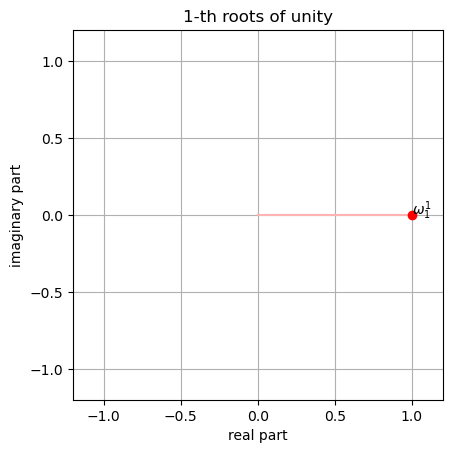

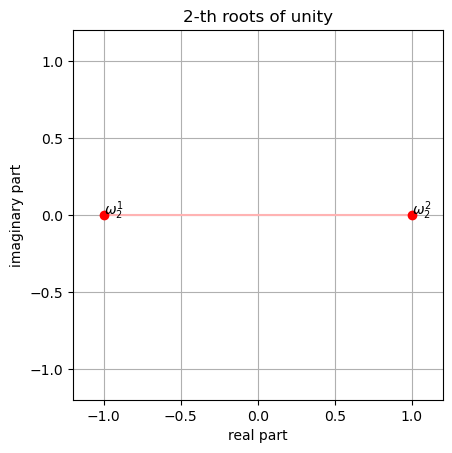

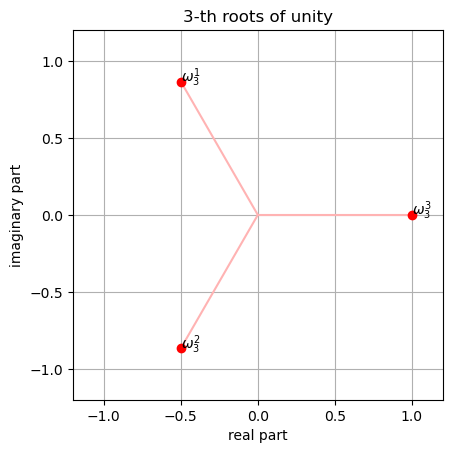

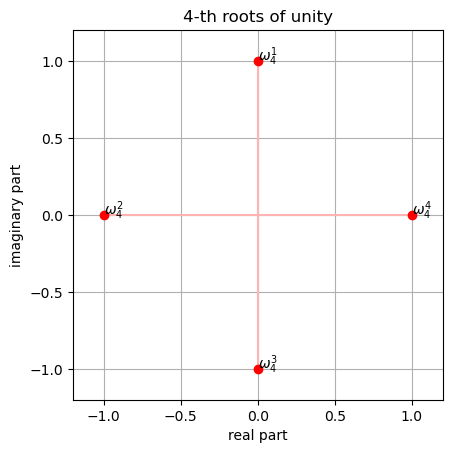

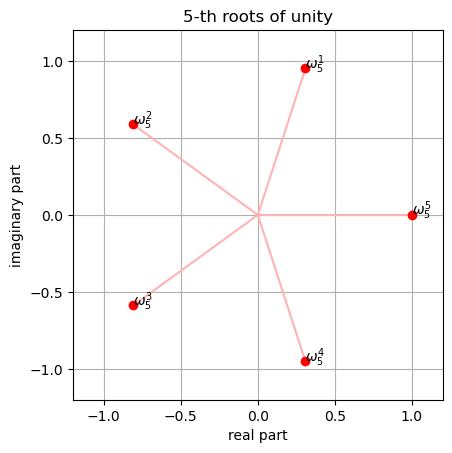

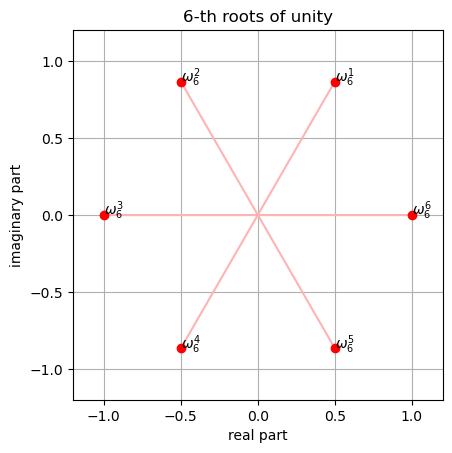

In [6]:
fig = figure()
#@manipulate for n in slider(1:20, value=7)
for n in 1:6
    ω = exp(2π*im/n)
    display(
    withfig(fig) do
        for j = 1:n
            z = ω ^ j
            plot([0,real(z)], [0,imag(z)], ls="solid", color=(1,.7,.7))
            plot(real(z), imag(z), "ro")
            text(real(z), imag(z), "\$\\omega_{$n}^{$j}\$")
        end
        axis("square")
        grid()
        xlabel("real part")
        ylabel("imaginary part")
        title("$n-th roots of unity")
        xlim(-1.2,1.2)
        ylim(-1.2,1.2)
    end
    )
end

They are called "roots of unity" because $\omega_n^j$ for $j = 0,\ldots,n-1$ (or $1,\ldots,n$) are *all* the solutions $z$ to 

$$
z^n = 1 .
$$

## Eigenvectors: The discrete Fourier transform (DFT)

In terms of $\omega_n$, the eigenvectors of a circulant matrix are easy: the **k-th eigenvector** $x^{(k)}$ ($k=0,\ldots,n-1$) for **any n×n circulant matrix** is simply

$$
x^{(k)} = \begin{pmatrix} \omega_n^{0k} \\ \omega_n^{1k} \\ \omega_n^{2k} \\ \vdots \\ \omega_n^{(n-1)k} \end{pmatrix}
$$

Therefore, the matrix $F$ whose columns are the eigenvectors is:

$$
F = \begin{pmatrix} x^{(0)} & x^{(1)} & \cdots & x^{(n-1)} \end{pmatrix}
$$

with entries

$$
\boxed{F_{jk} = x^{(k)}_j = \omega_n^{jk} = e^{\frac{2\pi i}{n} jk}}.
$$

Multiplying a vector by $F$ is called a [discrete Fourier transform (DFT)](https://en.wikipedia.org/wiki/Discrete_Fourier_transform).  This is one of the most important matrices in the world!  (It is sort of a finite, computer-friendly analogue to a Fourier series if you've seen those before.)

Before we show this, let's try it:

In [7]:
# define a function to create the n×n matrix F for any n:
F(n) = [exp((2π*im/n)*j*k) for j=0:n-1, k=0:n-1]

F (generic function with 1 method)

The $2\times2$ and $4\times 4$ DFT matrices $F$ are quite simple, for example
$$
F_{2\times 2} = \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}
$$

$$
F_{4\times 4} = \begin{pmatrix} 1 & 1 & 1 & 1 \\ 1 & i & -1 & -i \\ 1 & -1 & 1 & -1 \\ 1 & -i & -1 & i \end{pmatrix}
$$

In [8]:
round.(F(4))

4×4 Matrix{ComplexF64}:
 1.0+0.0im   1.0+0.0im   1.0+0.0im   1.0+0.0im
 1.0+0.0im   0.0+1.0im  -1.0+0.0im  -0.0-1.0im
 1.0+0.0im  -1.0+0.0im   1.0-0.0im  -1.0+0.0im
 1.0+0.0im  -0.0-1.0im  -1.0+0.0im   0.0+1.0im

Let's check that it diagonalizes our $7 \times 7$ mass-and-spring matrix $A$ from earlier.  We should have $F^{-1} A F = \Lambda$:

In [9]:
round.(inv(F(7)) * A * F(7), digits=3) # F⁻¹AF = Λ, rounded to 3 digits

7×7 Matrix{ComplexF64}:
 -0.0+0.0im   -0.0+0.0im   -0.0+0.0im  …   -0.0-0.0im   -0.0+0.0im
  0.0-0.0im  0.753+0.0im    0.0+0.0im       0.0+0.0im    0.0+0.0im
  0.0+0.0im   -0.0+0.0im  2.445-0.0im      -0.0+0.0im    0.0+0.0im
  0.0+0.0im    0.0-0.0im    0.0-0.0im      -0.0-0.0im   -0.0+0.0im
  0.0+0.0im    0.0+0.0im    0.0+0.0im      -0.0+0.0im   -0.0+0.0im
  0.0+0.0im   -0.0+0.0im   -0.0+0.0im  …  2.445-0.0im   -0.0+0.0im
 -0.0-0.0im    0.0+0.0im   -0.0-0.0im      -0.0-0.0im  0.753-0.0im

Compare the diagonal entries to the eigenvalues:

In [10]:
eigvals(A)

7-element Vector{Float64}:
 -6.847820921420924e-16
  0.7530203962825327
  0.7530203962825328
  2.4450418679126287
  2.4450418679126287
  3.801937735804838
  3.801937735804838

In [11]:
diag(inv(F(7)) * A * F(7)) # diagonal entries

7-element Vector{ComplexF64}:
 -2.7755575615628914e-17 + 0.0im
      0.7530203962825329 + 8.231328092213654e-18im
      2.4450418679126287 - 8.127363310989668e-17im
      3.8019377358048376 - 8.058346821283383e-17im
      3.8019377358048394 + 1.2783350539335312e-16im
      2.4450418679126296 - 2.3118001670187046e-16im
      0.7530203962825329 - 1.8759081285465905e-17im

Yup!

Since $A$ is real-symmetric, you may wonder why the eigenvectors are not real as well.  But they **could have been chosen** real.  For a real-symmetric circulant matrix, the real and imaginary parts of the eigenvectors are themselves eigenvectors.  This is why most of the eigenvalues come in pairs!  (The only eigenvalues that don't come in pairs correspond to eigenvectors $x^{(k)}$ that are purely real, e.g. $x^{(0)} = (1,1,\ldots,1)$.)  These real and imaginary eigenvectors turn out to correspond to a [discrete cosine transform (DCT)](https://en.wikipedia.org/wiki/Discrete_cosine_transform) and a [discrete sine transform (DST)](https://en.wikipedia.org/wiki/Discrete_sine_transform).

But this is a nice example where complex numbers actually turn out to be *easier* than real numbers, because the rule $e^x e^y = e^{x+y}$ for multiplying exponentials are simpler than the identities for multiplying sines and cosines.

## Derivation and eigenvalues

Why does this work?  It's easy to see if we take our formula from above for $Cx$ and multiply it by an eigenvector.  Let $y = C x^{(k)}$.  Then the ℓ-th component is:

$$
y_\ell = \sum_{j=0}^{n-1} c_{j-\ell} \omega_n^{jk} = \omega_n^{\ell k} \sum_{j=0}^{n-1} c_{j-\ell} \omega_n^{(j-\ell)k}
$$

But the remaining sum is now **independent of ℓ**: because both $c_j$ and $\omega_n^j$ are periodic in $j$, all $j \to j - \ell$ does is to re-arrange the numbers being summed (a circular shift), so you get the **same sum**.  And $\omega_n^{\ell k} = x^{(k)}$, so we have:

$$
C x^{(k)} = \lambda_k x^{(k)}
$$

where

$$
\lambda_k = \sum_{j=0}^{n-1} c_{j} \omega_n^{jk}
$$

But if we define a vector $\hat{c} = (\lambda_0, \lambda_1, \ldots, \lambda_{n-1})$, then

$$
\hat{c} = F c
$$

That is, the **eigenvalues are the DFT of c** (where c = first row of C).

Let's check it:

In [12]:
F(7) * A[:,1] # DFT of first row/column of A

7-element Vector{ComplexF64}:
                0.0 + 0.0im
  0.753020396282533 + 1.1102230246251565e-16im
  2.445041867912629 - 1.1102230246251565e-16im
 3.8019377358048385 - 6.661338147750939e-16im
  3.801937735804838 - 8.881784197001252e-16im
 2.4450418679126282 - 2.220446049250313e-16im
 0.7530203962825321 + 8.881784197001252e-16im

In [13]:
eigvals(A)

7-element Vector{Float64}:
 -6.847820921420924e-16
  0.7530203962825327
  0.7530203962825328
  2.4450418679126287
  2.4450418679126287
  3.801937735804838
  3.801937735804838

Yup, they match!

# Unitarity

The DFT matrix F is special in many ways.  It is symmetric, but *not* Hermitian, so its eigenvalues are *not* real.  However, it has **orthogonal columns**, which we can see from $F^H F$ for $n=7$:

In [14]:
round.(F(7)' * F(7), digits=3)

7×7 Matrix{ComplexF64}:
  7.0+0.0im  -0.0-0.0im  -0.0+0.0im  …   0.0+0.0im   0.0+0.0im   0.0+0.0im
 -0.0+0.0im   7.0+0.0im  -0.0+0.0im     -0.0+0.0im   0.0+0.0im   0.0+0.0im
 -0.0-0.0im  -0.0-0.0im   7.0-0.0im     -0.0+0.0im  -0.0+0.0im   0.0+0.0im
  0.0-0.0im  -0.0-0.0im  -0.0-0.0im     -0.0+0.0im  -0.0+0.0im  -0.0+0.0im
  0.0-0.0im  -0.0-0.0im  -0.0-0.0im      7.0-0.0im   0.0+0.0im   0.0+0.0im
  0.0-0.0im   0.0-0.0im  -0.0-0.0im  …   0.0-0.0im   7.0+0.0im  -0.0+0.0im
  0.0-0.0im   0.0-0.0im   0.0-0.0im      0.0-0.0im  -0.0+0.0im   7.0+0.0im

(It is a straightforward exercise to show this, e.g. using the [geometric-series](https://en.wikipedia.org/wiki/Geometric_series) summation formula.)

The columns are orthogonal but not orthonormal because they have length $\sqrt{n}$ (the lengths squared are $n$, which is what shows up on the diagonal of $F^H F$ above).  But this means that if we divide by their length, then:

$$
\frac{1}{\sqrt{n}} F
$$

is a **unitary** matrix.  Equivalently:

$$
F^{-1} = \frac{1}{n} F^H = \frac{1}{n} \bar{F},
$$

where we have used the fact that $F^T = F$.  This is the **inverse discrete Fourier transform (IDFT)**.

Note that this means that **every circulant matrix C has orthogonal eigenvectors** (the columns of F).  (Even if the matrix C is not Hermitian or one of the similar cases we have seen so far!)

# Fast Fourier transforms (FFTs)

The product $Fx$ for a vector $x$ is the DFT of $x$.  At first glance, it seems like it would require $\sim n^2$ operations ($n$ dot products) like any other matrix–vector multiplication. 

One of the most amazing facts of computational science is that it is possible to compute the DFT $Fx$ in only $\sim n \log n$ operations (and $\sim n$ storage), by a [fast Fourier transform (FFT) algorithm](https://en.wikipedia.org/wiki/Fast_Fourier_transform).  FFT algorithms mean that DFTs and circulant matrices become practical to deal with even for huge $n$, and are are the **core of a huge number of practical computational algorithms**.

(From a linear-algebra viewpoint, it turns out that the "dense" matrix $F$ factors into a **product** of $\sim \log n$ **sparse** matrices.)

FFTs aren't too complicated to understand (the simplest ones can be derived in a few lines of algebra), but they are a bit outside the scope of 18.06.  But `fft(x)` functions are available in Julia (via the [FFTW.jl package](https://github.com/JuliaMath/FFTW.jl), for example, and in every other computational-science environment:

In [15]:
using FFTW

In [16]:
fft(A[:,1]) # computes the same thing as F(7) * A[:,1], but much faster

7-element Vector{ComplexF64}:
                0.0 + 0.0im
  0.753020396282533 + 0.0im
 2.4450418679126287 + 0.0im
  3.801937735804838 + 0.0im
  3.801937735804838 + 0.0im
 2.4450418679126287 + 0.0im
  0.753020396282533 + 0.0im

But now that we know that $F$ diagonalizes any circulant matrix, it leads to an amazing fact: **you can multiply Cx for any circulant matrix in ~ n log n operations and ~ n storage**.  

Specifically, $C = F \Lambda F^{-1} = F \frac{\Lambda}{n} \bar{F}$, so to multiply $Cx$ we just need to:

1. Multiply $\hat{x} = \bar{F} x$.  This can be done by an (inverse) FFT in $\sim n log n$ operations.

2. Multiply each component of $\hat{x}$ by the eigenvalues $\lambda_k/n$.  The eigenvalues can be computed by multiply $F$ by the first row of $C$, which can be done by an FFT in $\sim n \log n$ operations.

3. Multiply by $F$ via another FFT in $\sim n \log n$ operations.

This means that **circulant matrices are perfectly suited to iterative solver algorithms** (e.g. the power method or steepest-descent), just like sparse matrices!

## A personal note

FFTs are near and dear to your instructor's heart — 20 years ago, partially for my final project in Prof. Alan Edelman's class 18.337, I developed a library for FFTs along with a friend of mine, [Matteo Frigo](https://www.linkedin.com/in/matteo-frigo-851212/).  Being arrogant MIT graduate students, we named it [FFTW: The Fastest Fourier Transform in the West](http://fftw.org/).  Fortunately, FFTW somewhat lived up to its name, and it is now the FFT library in Matlab, in Julia, and in many other software packages.

![FFTW logo](http://fftw.org/fftw-logo-med.gif)